In [1]:
%matplotlib inline
import csv
import logging
import os
import random
import sys
import pickle
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data = pickle.load(open("../resources/adaptabert_NER/conll_train.pkl", 'rb'))

In [3]:
num_token_lower_bound = 30

low_mu_num_token = 15
high_mu_num_token = 25
sigma_num_token = 4
spur_succ_rate = 0.9
test_spur_succ_rate = 0.5
pos_prefix = ['Positive', '.']
neg_prefix = ['Negative', '.']

In [4]:
qual_data_len = sum([1 for e in data if len(e[0]) >= num_token_lower_bound])
print(qual_data_len)

1980


In [5]:
train_pos_size = 750
train_total_size = 1500
test_pos_size = 240
test_total_size = 480
assert train_total_size + test_total_size == qual_data_len

In [6]:
random.seed(2021)

sub_data = []
for e in data:
    if len(e[0]) >= num_token_lower_bound:
        sub_data.append(e[0][:num_token_lower_bound])
        
random.shuffle(sub_data)

train_data = sub_data[:train_total_size]
test_data = sub_data[-test_total_size:]

In [7]:
def modify_data(data, pos_size, low_mu, high_mu, sigma, pos_prefix, neg_prefix, spur_succ_rate, seed):
    random.seed(seed)
    np.random.seed(seed)
    
    neg_size = len(data) - pos_size
    pos_rand_len_list = [int(e) for e in np.random.normal(high_mu, sigma, pos_size)]
    neg_rand_len_list = [int(e) for e in np.random.normal(low_mu, sigma, neg_size)]
    
    pos_prefix_list = [pos_prefix if i < int(pos_size * spur_succ_rate) else neg_prefix for i in range(pos_size)]
    neg_prefix_list = [neg_prefix if i < int(neg_size * spur_succ_rate) else pos_prefix for i in range(neg_size)]
    random.shuffle(pos_prefix_list)
    random.shuffle(neg_prefix_list)
    
    new_data = []
    for tokens, rand_len, prefix in zip(data[:pos_size], pos_rand_len_list, pos_prefix_list):
        new_tokens = prefix + tokens[:rand_len]
        if prefix == pos_prefix:
            spur_id = 1
        else:
            spur_id = 0
        new_data.append((new_tokens, 1, [rand_len, spur_id]))
    for tokens, rand_len, prefix in zip(data[-neg_size:], neg_rand_len_list, neg_prefix_list):
        new_tokens = prefix + tokens[:rand_len]
        if prefix == pos_prefix:
            spur_id = 1
        else:
            spur_id = 0
        new_data.append((new_tokens, 0, [rand_len, spur_id]))
    random.shuffle(new_data)
    
    return new_data

In [8]:
new_train_data = modify_data(train_data, train_pos_size, low_mu_num_token, high_mu_num_token, sigma_num_token,
                             pos_prefix, neg_prefix, spur_succ_rate, 2022)

In [9]:
new_test_data = modify_data(test_data, test_pos_size, low_mu_num_token, high_mu_num_token, sigma_num_token,
                            pos_prefix, neg_prefix, test_spur_succ_rate, 2023)

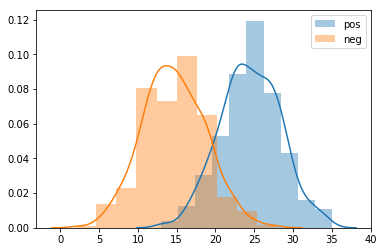

In [10]:
sns.distplot([e[2][0] for e in new_train_data if e[1] == 1], bins=10, label='pos')
sns.distplot([e[2][0] for e in new_train_data if e[1] == 0], bins=10, label='neg')
plt.legend()
plt.show()

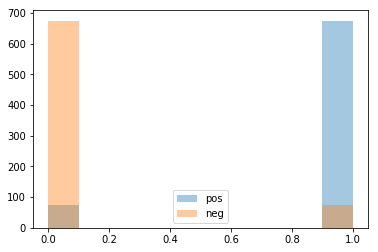

In [11]:
sns.distplot([e[2][1] for e in new_train_data if e[1] == 1], bins=10, kde=False, label='pos')
sns.distplot([e[2][1] for e in new_train_data if e[1] == 0], bins=10, kde=False, label='neg')
plt.legend()
plt.show()

In [ ]:
sum([int(e[2][0] >= 20) == e[1] for e in new_train_data]) / len(new_train_data)

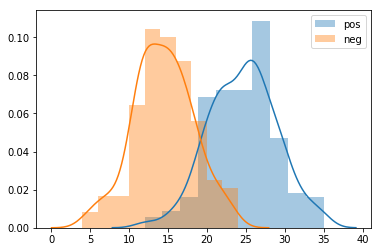

In [12]:
sns.distplot([e[2][0] for e in new_test_data if e[1] == 1], bins=10, label='pos')
sns.distplot([e[2][0] for e in new_test_data if e[1] == 0], bins=10, label='neg')
plt.legend()
plt.show()

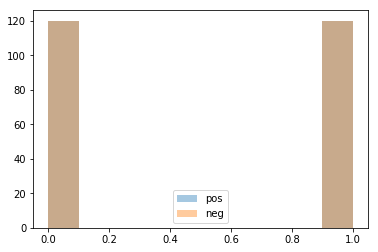

In [14]:
sns.distplot([e[2][1] for e in new_test_data if e[1] == 1], kde=False, bins=10, label='pos')
sns.distplot([e[2][1] for e in new_test_data if e[1] == 0], kde=False, bins=10, label='neg')
plt.legend()
plt.show()

In [15]:
sum([int(e[2][0] >= 20) == e[1] for e in new_test_data]) / len(new_test_data)

0.9

In [16]:
pickle.dump(new_train_data, open("synth_train.pkl", 'wb'))
pickle.dump(new_test_data, open("synth_dev.pkl", 'wb'))

In [17]:
len(train_data), len(test_data)

(1500, 480)

In [18]:
def modify_data_no_spur(data, pos_size, low_mu, high_mu, sigma, pos_prefix, neg_prefix, spur_succ_rate, seed):
    random.seed(seed)
    np.random.seed(seed)
    
    neg_size = len(data) - pos_size
    pos_rand_len_list = [int(e) for e in np.random.normal(high_mu, sigma, pos_size)]
    neg_rand_len_list = [int(e) for e in np.random.normal(low_mu, sigma, neg_size)]
    
    pos_prefix_list = [pos_prefix if i < int(pos_size * spur_succ_rate) else neg_prefix for i in range(pos_size)]
    neg_prefix_list = [neg_prefix if i < int(neg_size * spur_succ_rate) else pos_prefix for i in range(neg_size)]
    random.shuffle(pos_prefix_list)
    random.shuffle(neg_prefix_list)
    
    new_data = []
    for tokens, rand_len, prefix in zip(data[:pos_size], pos_rand_len_list, pos_prefix_list):
        new_tokens = tokens[:rand_len] # no prefix
        if prefix == pos_prefix:
            spur_id = 1
        else:
            spur_id = 0
        new_data.append((new_tokens, 1, [rand_len, spur_id]))
    for tokens, rand_len, prefix in zip(data[-neg_size:], neg_rand_len_list, neg_prefix_list):
        new_tokens = tokens[:rand_len] # no prefix
        if prefix == pos_prefix:
            spur_id = 1
        else:
            spur_id = 0
        new_data.append((new_tokens, 0, [rand_len, spur_id]))
    random.shuffle(new_data)
    
    return new_data

In [19]:
new_train_data = modify_data_no_spur(train_data, train_pos_size, low_mu_num_token, high_mu_num_token, sigma_num_token,
                                     pos_prefix, neg_prefix, spur_succ_rate, 2022)

In [20]:
new_test_data = modify_data_no_spur(test_data, test_pos_size, low_mu_num_token, high_mu_num_token, sigma_num_token,
                                    pos_prefix, neg_prefix, test_spur_succ_rate, 2023)

In [22]:
pickle.dump(new_train_data, open("no_spur/synth_train.pkl", 'wb'))
pickle.dump(new_test_data, open("no_spur/synth_dev.pkl", 'wb'))

## Held-out test set

In [26]:
data = pickle.load(open("../resources/adaptabert_NER/conll_test.pkl", 'rb'))

In [27]:
qual_data_len = sum([1 for e in data if len(e[0]) >= num_token_lower_bound])
print(qual_data_len)

551


In [28]:
train_pos_size = 25
train_total_size = 51
test_pos_size = 250
test_total_size = 500
assert train_total_size + test_total_size == qual_data_len

In [29]:
random.seed(2021)

sub_data = []
for e in data:
    if len(e[0]) >= num_token_lower_bound:
        sub_data.append(e[0][:num_token_lower_bound])
        
random.shuffle(sub_data)

train_data = sub_data[:train_total_size]
test_data = sub_data[-test_total_size:]

In [30]:
new_train_data = modify_data(train_data, train_pos_size, low_mu_num_token, high_mu_num_token, sigma_num_token,
                             pos_prefix, neg_prefix, spur_succ_rate, 2022)

In [31]:
new_test_data = modify_data(test_data, test_pos_size, low_mu_num_token, high_mu_num_token, sigma_num_token,
                            pos_prefix, neg_prefix, test_spur_succ_rate, 2023)

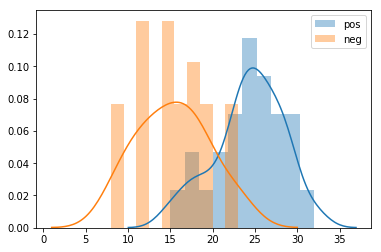

In [32]:
sns.distplot([e[2][0] for e in new_train_data if e[1] == 1], bins=10, label='pos')
sns.distplot([e[2][0] for e in new_train_data if e[1] == 0], bins=10, label='neg')
plt.legend()
plt.show()

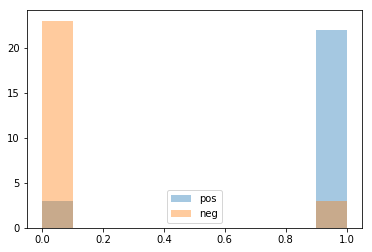

In [33]:
sns.distplot([e[2][1] for e in new_train_data if e[1] == 1], bins=10, kde=False, label='pos')
sns.distplot([e[2][1] for e in new_train_data if e[1] == 0], bins=10, kde=False, label='neg')
plt.legend()
plt.show()

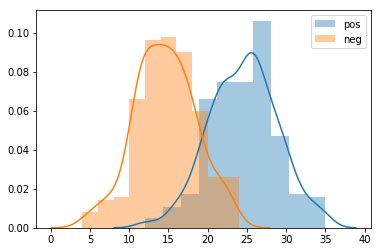

In [34]:
sns.distplot([e[2][0] for e in new_test_data if e[1] == 1], bins=10, label='pos')
sns.distplot([e[2][0] for e in new_test_data if e[1] == 0], bins=10, label='neg')
plt.legend()
plt.show()

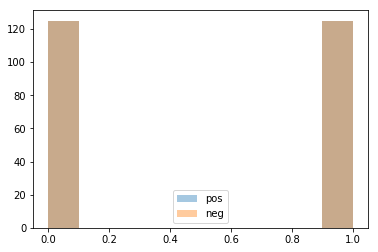

In [35]:
sns.distplot([e[2][1] for e in new_test_data if e[1] == 1], kde=False, bins=10, label='pos')
sns.distplot([e[2][1] for e in new_test_data if e[1] == 0], kde=False, bins=10, label='neg')
plt.legend()
plt.show()

In [36]:
sum([int(e[2][0] >= 20) == e[1] for e in new_test_data]) / len(new_test_data)

0.892

In [37]:
pickle.dump(new_test_data, open("synth_test.pkl", 'wb'))

In [38]:
len(train_data), len(test_data)

(51, 500)

In [39]:
new_train_data = modify_data_no_spur(train_data, train_pos_size, low_mu_num_token, high_mu_num_token, sigma_num_token,
                                     pos_prefix, neg_prefix, spur_succ_rate, 2022)

In [40]:
new_test_data = modify_data_no_spur(test_data, test_pos_size, low_mu_num_token, high_mu_num_token, sigma_num_token,
                                    pos_prefix, neg_prefix, test_spur_succ_rate, 2023)

In [41]:
pickle.dump(new_test_data, open("no_spur/synth_test.pkl", 'wb'))